<a href="https://colab.research.google.com/github/GlennSR/Stereo_Visual_Odometry/blob/main/my_stereo_visual_odometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Questão 2 - Odometria Visual com câmera stereo**
O objetivo dessa questão é de desenvolver um algoritmo de estimação do deslocamento de um carro utilizando como dados de entrada imagens de duas câmeras posicionadas no capô e espaçadas entre si de 0.573 m.

Para resolver essa questão, eu busquei auxílio em dois suportes que principais, meu material de curso sobre Visão Geométrica (Matéria aprendida durante meu Master na França) e em um projeto de Odometria Visual que encontrei durante minhas buscas sobre Estado da Arte. O link para esse projeto é https://github.com/niconielsen32/ComputerVision/tree/master/VisualOdometry (Vídeo: https://www.youtube.com/watch?v=WV3ZiPqd2G4)

Nesse projeto que utilizei como base para desenvolver o meu código, o autor adota uma aproximação um pouco diferente, onde ele considera, além da predição da posição do carro, os valores de Ground Truth, que ele utiliza para calcular os erros da posição estimada em relação à posição real. Mas como no nosso caso nós não temos os valores de Ground Truth, eu exclui essa parte do código e só deixei a parte de estimação.

Abaixo deixo o código desenvolvido para responder ao problema.


In [ ]:
!git clone https://github.com/GlennSR/Stereo_Visual_Odometry.git
%load https://github.com/GlennSR/Stereo_Visual_Odometry/tree/main/KITTI_sequence_3/calib.txt

fatal: destination path 'Stereo_Visual_Odometry' already exists and is not an empty directory.


In [ ]:
# Importando as bibliotecas
import os
import numpy as np
import cv2
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

from Stereo_Visual_Odometry.lib.visualization import plotting
# from Stereo_Visual_Odometry.lib.visualization.video import play_trip

from tqdm import tqdm

In [ ]:
class VisualOdometry():
    def __init__(self, data_dir):
        self.K_l, self.P_l, self.K_r, self.P_r = self._load_calib(data_dir + '/calib.txt')
        self.images_l = self._load_images(data_dir + '/image_l')
        self.images_r = self._load_images(data_dir + '/image_r')

        block = 11
        P1 = block * block * 8
        P2 = block * block * 32
        self.disparity = cv2.StereoSGBM_create(minDisparity=0, numDisparities=32, blockSize=block, P1=P1, P2=P2)
        self.disparities = [
            np.divide(self.disparity.compute(self.images_l[0], self.images_r[0]).astype(np.float32), 16)]
        self.fastFeatures = cv2.FastFeatureDetector_create()

        self.lk_params = dict(winSize=(15, 15),
                              flags=cv2.MOTION_AFFINE,
                              maxLevel=3,
                              criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.03))

    @staticmethod
    def _load_calib(filepath):
        """
        Loads the calibration of the camera
        Parameters
        ----------
        filepath (str): The file path to the camera file

        Returns
        -------
        K_l (ndarray): Intrinsic parameters for left camera. Shape (3,3)
        P_l (ndarray): Projection matrix for left camera. Shape (3,4)
        K_r (ndarray): Intrinsic parameters for right camera. Shape (3,3)
        P_r (ndarray): Projection matrix for right camera. Shape (3,4)
        """
        with open(filepath, 'r') as f:
            params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
            P_l = np.reshape(params, (3, 4))
            K_l = P_l[0:3, 0:3]
            params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
            P_r = np.reshape(params, (3, 4))
            K_r = P_r[0:3, 0:3]
        return K_l, P_l, K_r, P_r


    @staticmethod
    def _load_images(filepath):
        """
        Loads the images

        Parameters
        ----------
        filepath (str): The file path to image dir

        Returns
        -------
        images (list): grayscale images. Shape (n, height, width)
        """
        image_paths = [os.path.join(filepath, file) for file in sorted(os.listdir(filepath))]
        images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]
        return images

    @staticmethod
    def _form_transf(R, t):
        """
        Makes a transformation matrix from the given rotation matrix and translation vector

        Parameters
        ----------
        R (ndarray): The rotation matrix. Shape (3,3)
        t (list): The translation vector. Shape (3)

        Returns
        -------
        T (ndarray): The transformation matrix. Shape (4,4)
        """
        T = np.eye(4, dtype=np.float64)
        T[:3, :3] = R
        T[:3, 3] = t
        return T

    def reprojection_residuals(self, dof, q1, q2, Q1, Q2):
        """
        Calculate the residuals

        Parameters
        ----------
        dof (ndarray): Transformation between the two frames. First 3 elements are the rotation vector and the last 3 is the translation. Shape (6)
        q1 (ndarray): Feature points in i-1'th image. Shape (n_points, 2)
        q2 (ndarray): Feature points in i'th image. Shape (n_points, 2)
        Q1 (ndarray): 3D points seen from the i-1'th image. Shape (n_points, 3)
        Q2 (ndarray): 3D points seen from the i'th image. Shape (n_points, 3)

        Returns
        -------
        residuals (ndarray): The residuals. In shape (2 * n_points * 2)
        """
        # Get the rotation vector
        r = dof[:3]
        # Create the rotation matrix from the rotation vector
        R, _ = cv2.Rodrigues(r)
        # Get the translation vector
        t = dof[3:]
        # Create the transformation matrix from the rotation matrix and translation vector
        transf = self._form_transf(R, t)

        # Create the projection matrix for the i-1'th image and i'th image
        f_projection = np.matmul(self.P_l, transf)
        b_projection = np.matmul(self.P_l, np.linalg.inv(transf))

        # Make the 3D points homogenize
        ones = np.ones((q1.shape[0], 1))
        Q1 = np.hstack([Q1, ones])
        Q2 = np.hstack([Q2, ones])

        # Project 3D points from i'th image to i-1'th image
        q1_pred = Q2.dot(f_projection.T)
        # Un-homogenize
        q1_pred = q1_pred[:, :2].T / q1_pred[:, 2]

        # Project 3D points from i-1'th image to i'th image
        q2_pred = Q1.dot(b_projection.T)
        # Un-homogenize
        q2_pred = q2_pred[:, :2].T / q2_pred[:, 2]

        # Calculate the residuals
        residuals = np.vstack([q1_pred - q1.T, q2_pred - q2.T]).flatten()
        return residuals

    def get_tiled_keypoints(self, img, tile_h, tile_w):
        """
        Splits the image into tiles and detects the 10 best keypoints in each tile

        Parameters
        ----------
        img (ndarray): The image to find keypoints in. Shape (height, width)
        tile_h (int): The tile height
        tile_w (int): The tile width

        Returns
        -------
        kp_list (ndarray): A 1-D list of all keypoints. Shape (n_keypoints)
        """
        def get_kps(x, y):
            # Get the image tile
            impatch = img[y:y + tile_h, x:x + tile_w]

            # Detect keypoints
            keypoints = self.fastFeatures.detect(impatch)

            # Correct the coordinate for the point
            for pt in keypoints:
                pt.pt = (pt.pt[0] + x, pt.pt[1] + y)

            # Get the 10 best keypoints
            if len(keypoints) > 10:
                keypoints = sorted(keypoints, key=lambda x: -x.response)
                return keypoints[:10]
            return keypoints
        # Get the image height and width
        h, w, *_ = img.shape

        # Get the keypoints for each of the tiles
        kp_list = [get_kps(x, y) for y in range(0, h, tile_h) for x in range(0, w, tile_w)]

        # Flatten the keypoint list
        kp_list_flatten = np.concatenate(kp_list)
        return kp_list_flatten

    def track_keypoints(self, img1, img2, kp1, max_error=4):
        """
        Tracks the keypoints between frames

        Parameters
        ----------
        img1 (ndarray): i-1'th image. Shape (height, width)
        img2 (ndarray): i'th image. Shape (height, width)
        kp1 (ndarray): Keypoints in the i-1'th image. Shape (n_keypoints)
        max_error (float): The maximum acceptable error

        Returns
        -------
        trackpoints1 (ndarray): The tracked keypoints for the i-1'th image. Shape (n_keypoints_match, 2)
        trackpoints2 (ndarray): The tracked keypoints for the i'th image. Shape (n_keypoints_match, 2)
        """
        # Convert the keypoints into a vector of points and expand the dims so we can select the good ones
        trackpoints1 = np.expand_dims(cv2.KeyPoint_convert(kp1), axis=1)

        # Use optical flow to find tracked counterparts
        trackpoints2, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, trackpoints1, None, **self.lk_params)

        # Convert the status vector to boolean so we can use it as a mask
        trackable = st.astype(bool)

        # Create a maks there selects the keypoints there was trackable and under the max error
        under_thresh = np.where(err[trackable] < max_error, True, False)

        # Use the mask to select the keypoints
        trackpoints1 = trackpoints1[trackable][under_thresh]
        trackpoints2 = np.around(trackpoints2[trackable][under_thresh])

        # Remove the keypoints there is outside the image
        h, w = img1.shape
        in_bounds = np.where(np.logical_and(trackpoints2[:, 1] < h, trackpoints2[:, 0] < w), True, False)
        trackpoints1 = trackpoints1[in_bounds]
        trackpoints2 = trackpoints2[in_bounds]

        return trackpoints1, trackpoints2

    def calculate_right_qs(self, q1, q2, disp1, disp2, min_disp=0.0, max_disp=100.0):
        """
        Calculates the right keypoints (feature points)

        Parameters
        ----------
        q1 (ndarray): Feature points in i-1'th left image. In shape (n_points, 2)
        q2 (ndarray): Feature points in i'th left image. In shape (n_points, 2)
        disp1 (ndarray): Disparity i-1'th image per. Shape (height, width)
        disp2 (ndarray): Disparity i'th image per. Shape (height, width)
        min_disp (float): The minimum disparity
        max_disp (float): The maximum disparity

        Returns
        -------
        q1_l (ndarray): Feature points in i-1'th left image. In shape (n_in_bounds, 2)
        q1_r (ndarray): Feature points in i-1'th right image. In shape (n_in_bounds, 2)
        q2_l (ndarray): Feature points in i'th left image. In shape (n_in_bounds, 2)
        q2_r (ndarray): Feature points in i'th right image. In shape (n_in_bounds, 2)
        """
        def get_idxs(q, disp):
            q_idx = q.astype(int)
            disp = disp.T[q_idx[:, 0], q_idx[:, 1]]
            return disp, np.where(np.logical_and(min_disp < disp, disp < max_disp), True, False)
        
        # Get the disparity's for the feature points and mask for min_disp & max_disp
        disp1, mask1 = get_idxs(q1, disp1)
        disp2, mask2 = get_idxs(q2, disp2)
        
        # Combine the masks 
        in_bounds = np.logical_and(mask1, mask2)
        
        # Get the feature points and disparity's there was in bounds
        q1_l, q2_l, disp1, disp2 = q1[in_bounds], q2[in_bounds], disp1[in_bounds], disp2[in_bounds]
        
        # Calculate the right feature points 
        q1_r, q2_r = np.copy(q1_l), np.copy(q2_l)
        q1_r[:, 0] -= disp1
        q2_r[:, 0] -= disp2
        
        return q1_l, q1_r, q2_l, q2_r

    def calc_3d(self, q1_l, q1_r, q2_l, q2_r):
        """
        Triangulate points from both images 
        
        Parameters
        ----------
        q1_l (ndarray): Feature points in i-1'th left image. In shape (n, 2)
        q1_r (ndarray): Feature points in i-1'th right image. In shape (n, 2)
        q2_l (ndarray): Feature points in i'th left image. In shape (n, 2)
        q2_r (ndarray): Feature points in i'th right image. In shape (n, 2)

        Returns
        -------
        Q1 (ndarray): 3D points seen from the i-1'th image. In shape (n, 3)
        Q2 (ndarray): 3D points seen from the i'th image. In shape (n, 3)
        """
        # Triangulate points from i-1'th image
        Q1 = cv2.triangulatePoints(self.P_l, self.P_r, q1_l.T, q1_r.T)
        # Un-homogenize
        Q1 = np.transpose(Q1[:3] / Q1[3])

        # Triangulate points from i'th image
        Q2 = cv2.triangulatePoints(self.P_l, self.P_r, q2_l.T, q2_r.T)
        # Un-homogenize
        Q2 = np.transpose(Q2[:3] / Q2[3])
        return Q1, Q2

    def estimate_pose(self, q1, q2, Q1, Q2, max_iter=100):
        """
        Estimates the transformation matrix

        Parameters
        ----------
        q1 (ndarray): Feature points in i-1'th image. Shape (n, 2)
        q2 (ndarray): Feature points in i'th image. Shape (n, 2)
        Q1 (ndarray): 3D points seen from the i-1'th image. Shape (n, 3)
        Q2 (ndarray): 3D points seen from the i'th image. Shape (n, 3)
        max_iter (int): The maximum number of iterations

        Returns
        -------
        transformation_matrix (ndarray): The transformation matrix. Shape (4,4)
        """
        early_termination_threshold = 5

        # Initialize the min_error and early_termination counter
        min_error = float('inf')
        early_termination = 0

        for _ in range(max_iter):
            # Choose 6 random feature points
            sample_idx = np.random.choice(range(q1.shape[0]), 6)
            sample_q1, sample_q2, sample_Q1, sample_Q2 = q1[sample_idx], q2[sample_idx], Q1[sample_idx], Q2[sample_idx]

            # Make the start guess
            in_guess = np.zeros(6)
            # Perform least squares optimization
            opt_res = least_squares(self.reprojection_residuals, in_guess, method='lm', max_nfev=200,
                                    args=(sample_q1, sample_q2, sample_Q1, sample_Q2))

            # Calculate the error for the optimized transformation
            # print('dof: ', opt_res.x)
            error = self.reprojection_residuals(opt_res.x, q1, q2, Q1, Q2)
            error = error.reshape((Q1.shape[0] * 2, 2))
            error = np.sum(np.linalg.norm(error, axis=1))

            # Check if the error is less the the current min error. Save the result if it is
            if error < min_error:
                min_error = error
                out_pose = opt_res.x
                early_termination = 0
            else:
                early_termination += 1
            if early_termination == early_termination_threshold:
                # If we have not fund any better result in early_termination_threshold iterations
                break

        # Get the rotation vector
        r = out_pose[:3]
        # Make the rotation matrix
        R, _ = cv2.Rodrigues(r)
        # Get the translation vector
        t = out_pose[3:]
        # Make the transformation matrix
        transformation_matrix = self._form_transf(R, t)
        return transformation_matrix

    def get_pose(self, i):
        """
        Calculates the transformation matrix for the i'th frame

        Parameters
        ----------
        i (int): Frame index

        Returns
        -------
        transformation_matrix (ndarray): The transformation matrix. Shape (4,4)
        """
        # Get the i-1'th image and i'th image
        img1_l, img2_l = self.images_l[i - 1:i + 1]

        # Get teh tiled keypoints
        kp1_l = self.get_tiled_keypoints(img1_l, 10, 20)

        # Track the keypoints
        tp1_l, tp2_l = self.track_keypoints(img1_l, img2_l, kp1_l)

        # Calculate the disparitie
        self.disparities.append(np.divide(self.disparity.compute(img2_l, self.images_r[i]).astype(np.float32), 16))

        # Calculate the right keypoints
        tp1_l, tp1_r, tp2_l, tp2_r = self.calculate_right_qs(tp1_l, tp2_l, self.disparities[i - 1], self.disparities[i])

        # Calculate the 3D points
        Q1, Q2 = self.calc_3d(tp1_l, tp1_r, tp2_l, tp2_r)

        # Estimate the transformation matrix
        transformation_matrix = self.estimate_pose(tp1_l, tp2_l, Q1, Q2)
        return transformation_matrix

In [ ]:
def plot_result_path(pred_path, w_title):
  pred_path = np.array(pred_path)

  pred_x, pred_y = pred_path.T
  xs = list(np.array([pred_x]).T)
  ys = list(np.array([pred_y]).T)

  plt.plot(xs, ys)
  plt.xticks(np.arange(-0.5, 1, 0.5))

  plt.xlabel('x - m')
  plt.ylabel('y - m')
  plt.grid()
  plt.title(w_title)

In [ ]:
def main():
    data_dir = 'Stereo_Visual_Odometry/KITTI_sequence_3'  # Try KITTI_sequence_2
    vo = VisualOdometry(data_dir)

    # play_trip(vo.images_l, vo.images_r)  # Comment out to not play the trip

    gt_path = []
    estimated_path = []
    for i in range(6):
        if i < 1:
            cur_pose = np.eye(4,4)
        else:
            transf = vo.get_pose(i)
            cur_pose = np.matmul(cur_pose, transf)
        estimated_path.append((cur_pose[0, 3], cur_pose[2, 3]))
    plot_result_path(estimated_path, "Estimated Path")
    plotting.visualize_paths(estimated_path, "Stereo Visual Odometry",
                            file_out=os.path.basename(data_dir) + ".html")

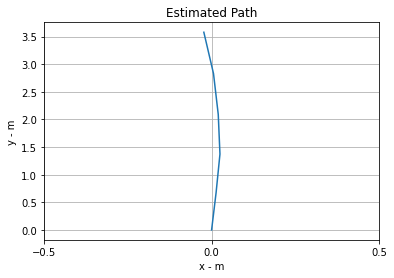

In [ ]:
if __name__ == "__main__":
    main()

#####**OBS: Para visualizar o resultado gerado como html, na esquerda do Colab abra a aba "Arquivos" e procure por *KITTI_sequence_3.html*, se ele não existir, tente atualizar a pasta clicando no segundo ícone à logo abaixo do nome "Arquivos"**

#**Referências:**
[1]https://www.youtube.com/watch?v=WV3ZiPqd2G4

[2]https://github.com/schvarcz/VisualOdometryPython

[3]https://github.com/AhmedHisham1/carla-visual-odometry
